# Stolen phones in a nightclub

## Scenario
Your friend owns a nightclub, and the nightclub is suffering an epidemic of stolen phones. At least one thief has been frequenting her club and stealing her visitors' phones. Her club has a licence scanner at its entrance, that records the name and date-of-birth of everyone who enters the club - so she should have the personal details of the thief or thieves; it's just mixed in with the details of her honest customers. She heard you call yourself a "data scientist", so has asked you to come up with a ranked list of up to 20 suspects to give to the police.

She's given you:
`visitor_log.csv` - details of who visited the club and on what day (those visiting 2AM Tuesday are counted as visiting on Monday).
`theft_log.csv' - a list of days on which thefts were reported to occur (again, thefts after midnight are counted as the previous day - we're being nice to you)

She wants from you:
- A list of ID details for the 20 most suspicious patrons, ranked from most-suspicious to least-suspicious.
- If you think there are fewer than 20 thieves, a list of ID details for everyone that you think is a thief.



# Please just follow the flow of the notebook!

In [9]:
import pandas as pd
from matplotlib.pyplot import plot
import numpy as np
from scipy.stats import zscore,normaltest
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)

Populating the interactive namespace from numpy and matplotlib


In [10]:
# First things first lets load the data
visitor_log = pd.read_csv('visitor_log.csv')
print visitor_log.shape

# After I loaded the first time the thief_log I noticed that there is no header, so I have changed the reading
# process adding the column name for the dates
thief_log = pd.read_csv('theft_log.csv', header=None,names=['theft_date'])
print thief_log.shape

(42727, 3)
(34, 1)


In [11]:
# looking at the data
visitor_log.head()

,visit_date,name,dob
0,2016-06-16,Samuel Casanova,1990-03-12
1,2016-06-16,Gerald Orozco,1990-10-05
2,2016-06-16,Sharon Davis,1990-10-18
3,2016-06-16,Spencer Spencer,1991-10-13
4,2016-06-16,Steven Estevez,1992-01-13


In [12]:
thief_log.head()

,theft_date
0,2017-01-01
1,2016-12-30
2,2016-12-25
3,2016-12-22
4,2016-12-19


In [13]:
# In a previous version of pandas there was a function called 'convert_objects', that function was used to
# infer automatically the type of the data in the columns
# Now that function is deprecated so I have to cast all the data to the correct type
visitor_log.visit_date = pd.to_datetime(visitor_log.visit_date)
visitor_log.dob = pd.to_datetime(visitor_log.dob)
visitor_log.name = visitor_log.name.astype(basestring)
visitor_log.dtypes

visit_date    datetime64[ns]
name                  object
dob           datetime64[ns]
dtype: object

In [14]:
thief_log.theft_date = pd.to_datetime(thief_log.theft_date)
thief_log.dtypes

theft_date    datetime64[ns]
dtype: object

In [15]:
# Lets see if there is any duplicate or missing data and remove it
visitor_log = visitor_log.dropna().drop_duplicates()
thief_log.csv = thief_log.dropna().drop_duplicates()
print visitor_log.shape
print thief_log.shape

(42727, 3)
(34, 1)


# All good! Now we can proceed

In [16]:
#Since there is the date record in each data set, it makes sense to merge them on the date.
# In this way we can later see who was in the nightclub when there was a robbery
log_merged = visitor_log.merge(thief_log,how='left', left_on='visit_date',right_on='theft_date')

In [17]:
# In order to plot, we need numerical values, so I am adding a boolean value that is 1 if there was a robbery and 
# zero otherwise
log_merged['theft_bool']= log_merged['theft_date'].apply(lambda x: 0 if pd.isnull(x) else 1)

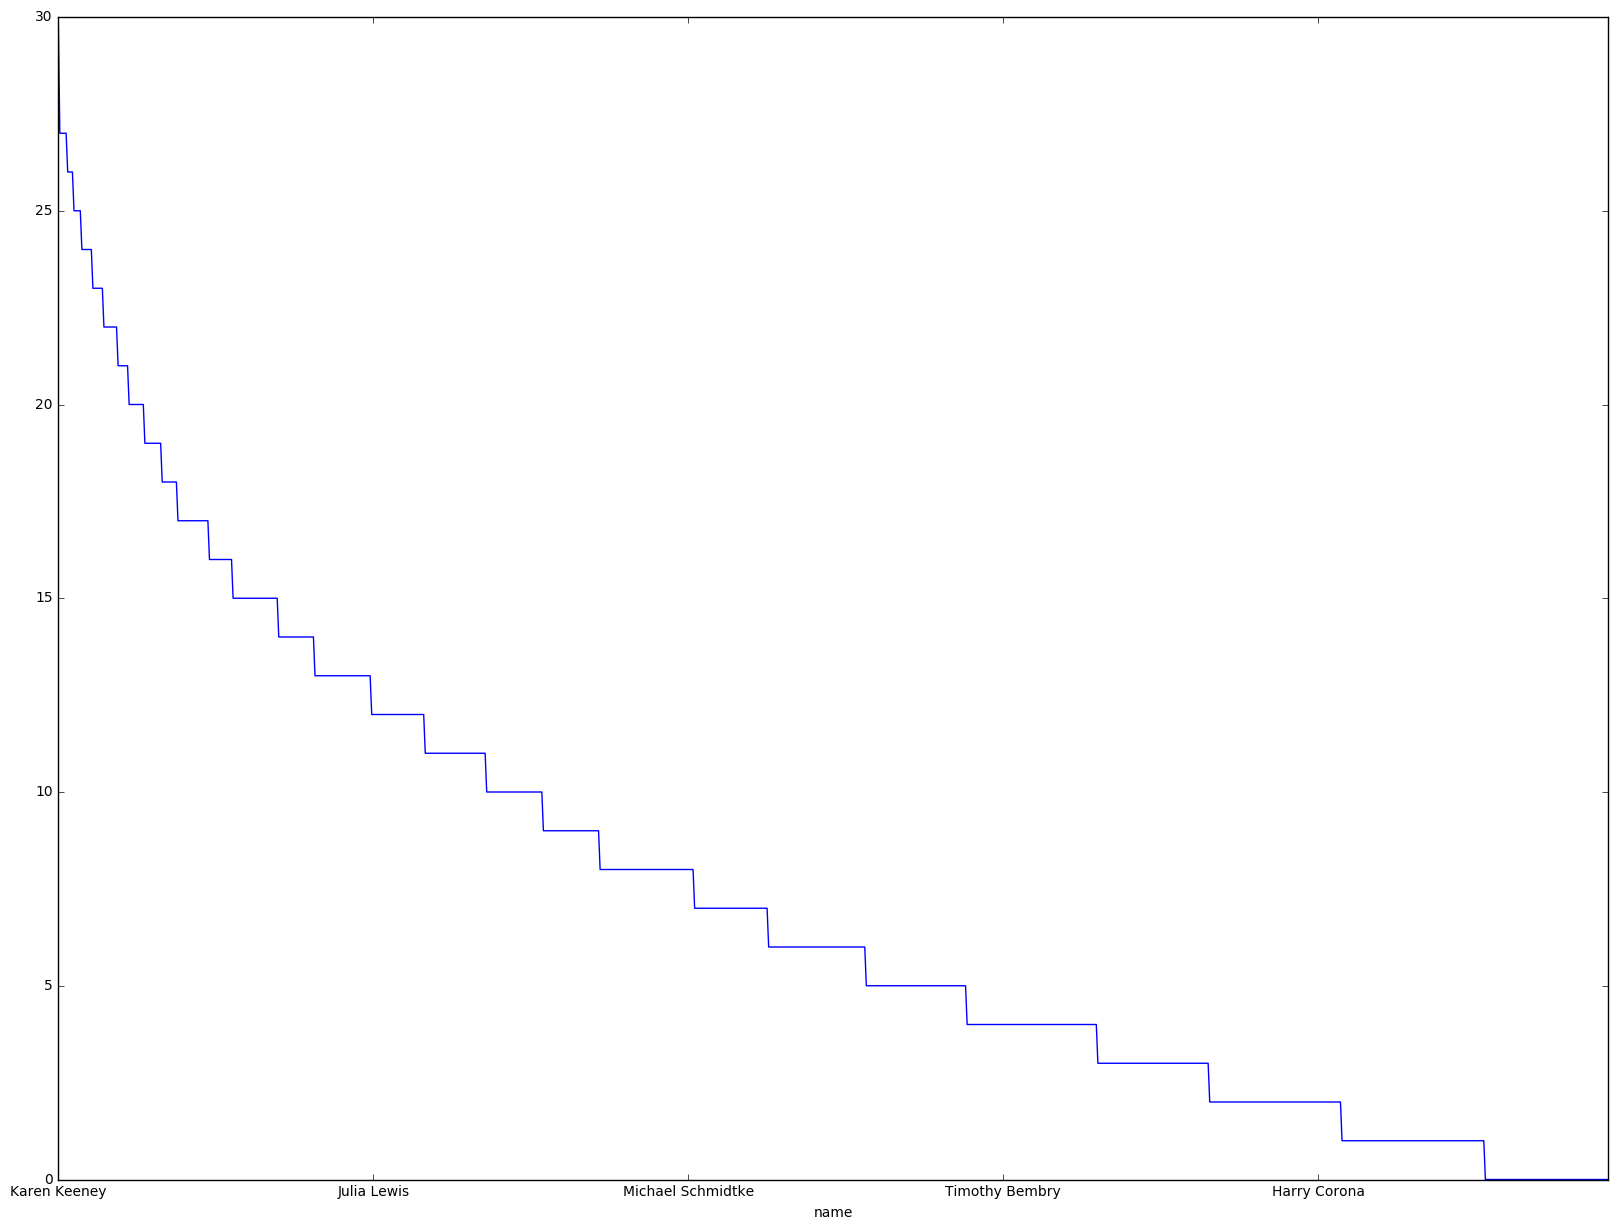

In [18]:
#Now it is possible to group the data by the visitor name and count how many times that visitor was at the club
# when there was a robbery.
# I sort the data in descending order and plot it
log_merged.groupby('name').theft_bool.sum().sort_values(ascending=False).plot(legend=False)

# It seems we have some interesting insight here.
# From the plot we can see that Karen Keeney is the visitor who was most often at the club when there was a robbery.

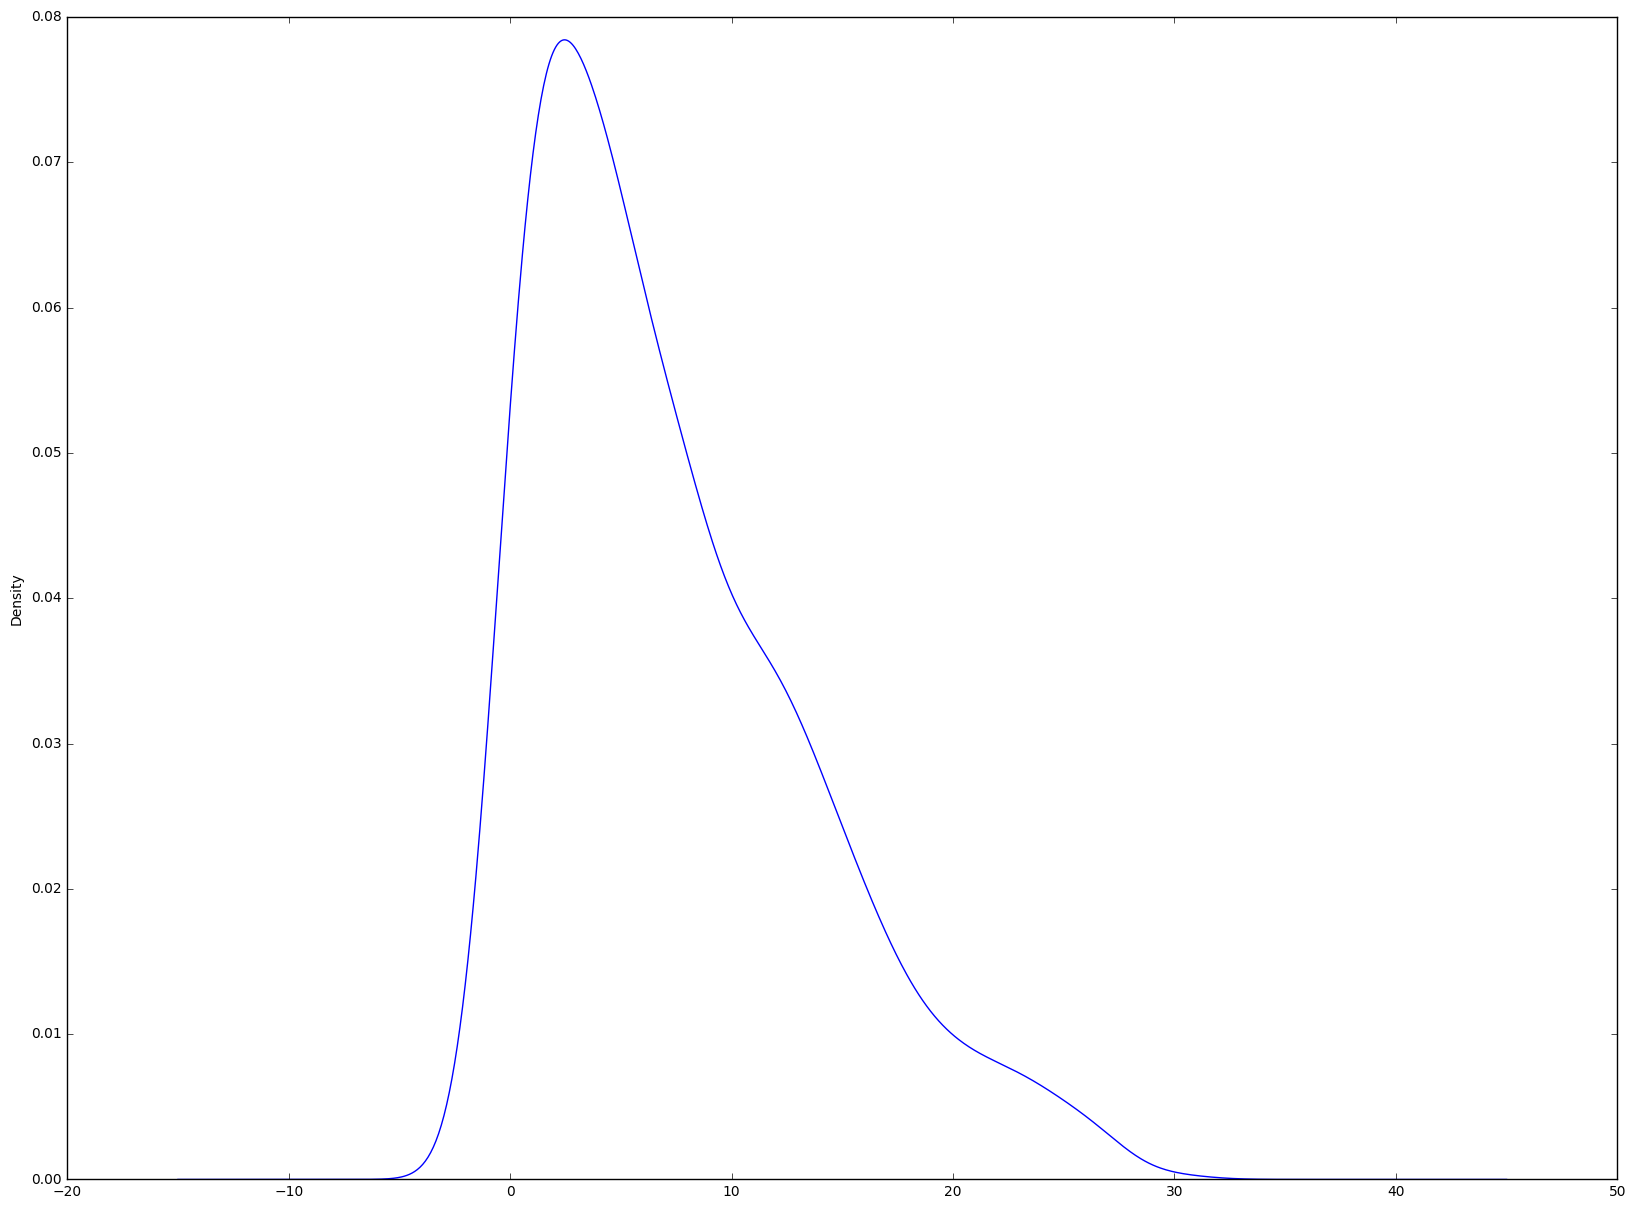

In [19]:
# Lets have a look what is the density distribution of this data
log_merged.groupby('name').theft_bool.sum().sort_values(ascending=False).plot(legend=False,kind='kde')

# Looks like a normal distribution!

In [20]:
# Now lets count how many times a visitor was at the club during a robbery
# lets remove the visitors who were never at the club during a robbery
theft_sum = log_merged.groupby('name').theft_bool.sum().sort_values(ascending=False).reset_index()
theft_sum = theft_sum[theft_sum.theft_bool!=0]
theft_sum.columns = ['name','robbery_count']
theft_sum.shape

(906, 2)

In [21]:
# Karen Keeney seems our thief! But lets not jump to conclusions
theft_sum.head(20)

,name,robbery_count
0,Karen Keeney,30
1,Patricia Whitley,27
2,Christine Victoria,27
3,Judith Sanders,27
4,Henry Brunson,27
5,Lynn Bernhart,27
6,Daniel Laster,26
7,Arthur Freund,26
8,Dale Kirkwood,26
9,Roger Ballance,26


# Since there were in total 34 theft days, it is clear that there is more than one thief.
# We will come back to this later on.

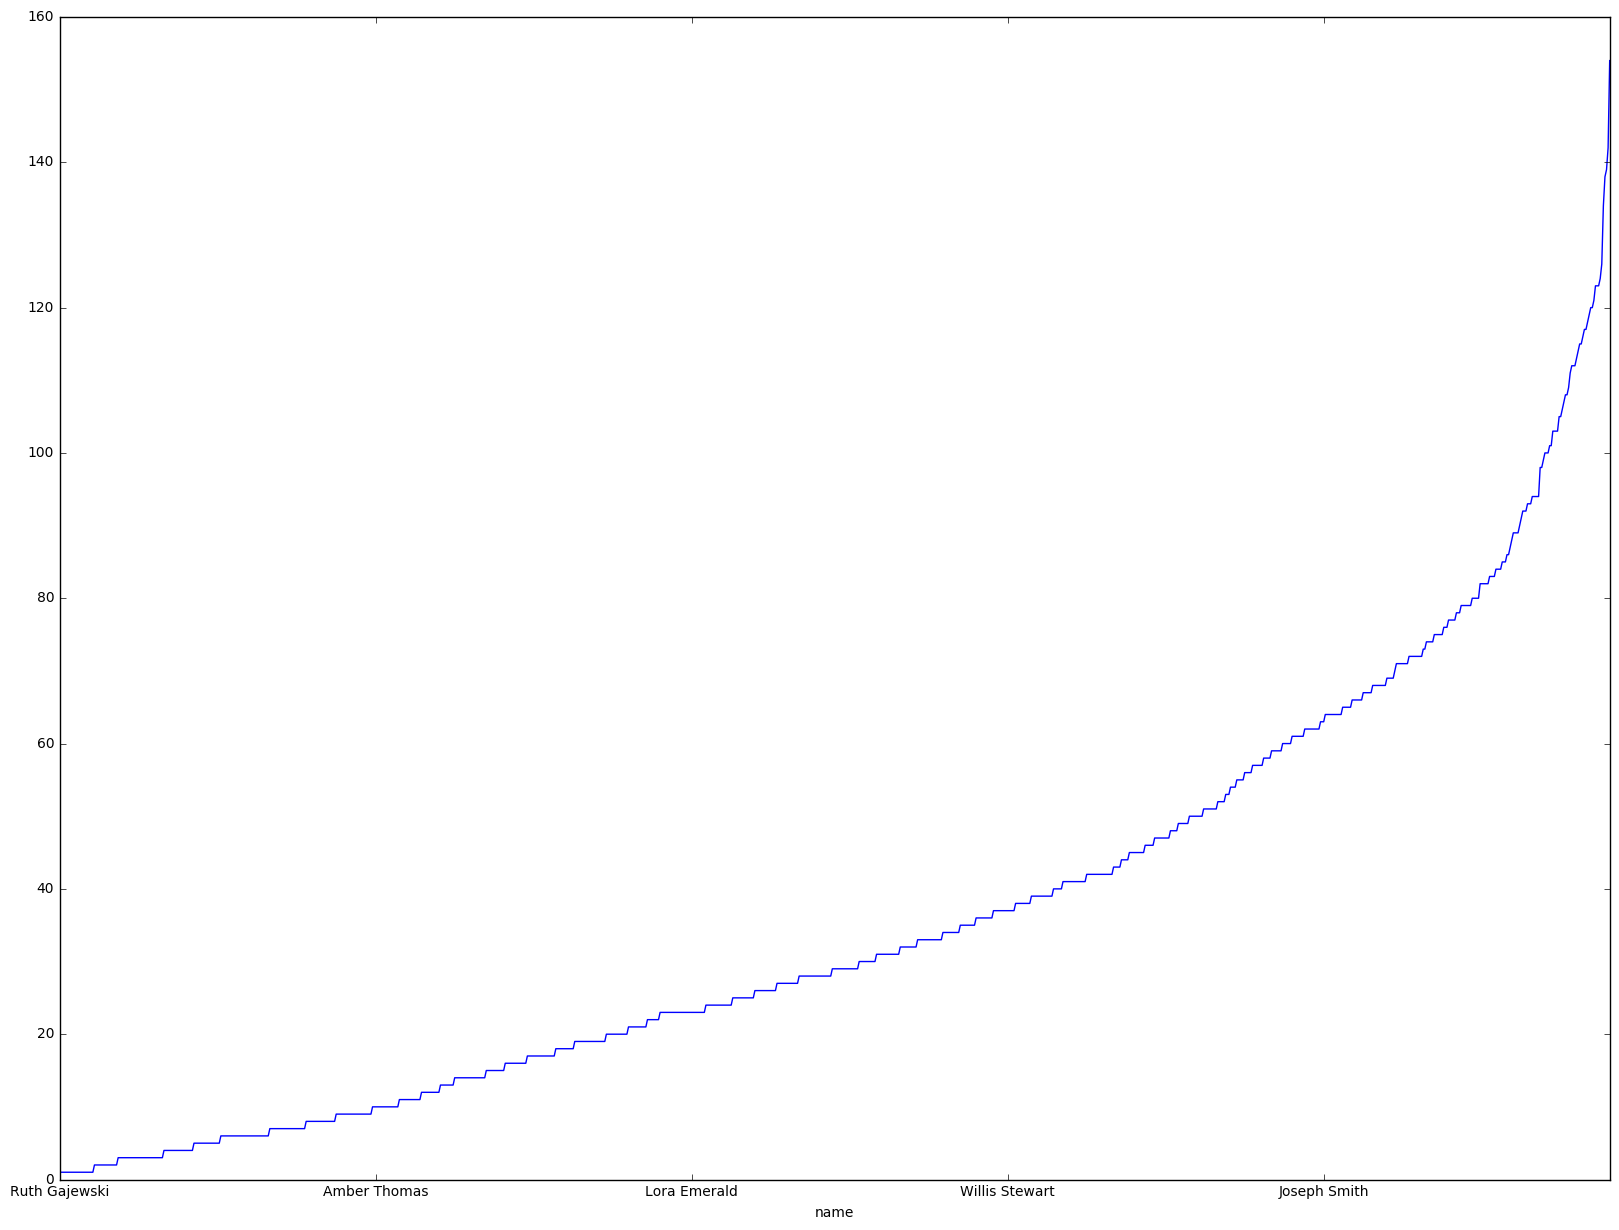

In [22]:
#Lets have a look at the visitors who where at the club when there was no robbery
not_theft = log_merged[log_merged.theft_bool!=1]
not_theft.groupby('name').theft_bool.count().sort_values().plot(legend=False)

In [23]:
# Lets store the previous count into a dataframe
not_theft_count = not_theft.groupby('name').theft_bool.count().sort_values().reset_index()
not_theft_count.columns=['name','not_robbery_count']

In [24]:
#Now its time to calculate some stats for the visitors!!
# I add the counts to the original dataset and make some new ones, the names should be self explanatory
final_stats = log_merged.merge(not_theft_count,how='left',left_on='name',right_on='name')
final_stats = final_stats.merge(theft_sum,how='left',left_on='name',right_on='name')
#here i replace missing values with zeros, this creates an 'artificial' value for the column theft_date
# but it doesnt matter since there is the theft_bool column now
final_stats.fillna(0,inplace=True)
final_stats['total_visits'] = final_stats.robbery_count + final_stats.not_robbery_count
final_stats['robbery_freq'] = final_stats.robbery_count/final_stats.total_visits
final_stats.head()

,visit_date,name,dob,theft_date,theft_bool,not_robbery_count,robbery_count,total_visits,robbery_freq
0,2016-06-16,Samuel Casanova,1990-03-12,1970-01-01,0,38.0,11.0,49.0,0.224490
1,2016-06-16,Gerald Orozco,1990-10-05,1970-01-01,0,19.0,2.0,21.0,0.095238
2,2016-06-16,Sharon Davis,1990-10-18,1970-01-01,0,39.0,1.0,40.0,0.025000
3,2016-06-16,Spencer Spencer,1991-10-13,1970-01-01,0,91.0,14.0,105.0,0.133333
4,2016-06-16,Steven Estevez,1992-01-13,1970-01-01,0,55.0,11.0,66.0,0.166667


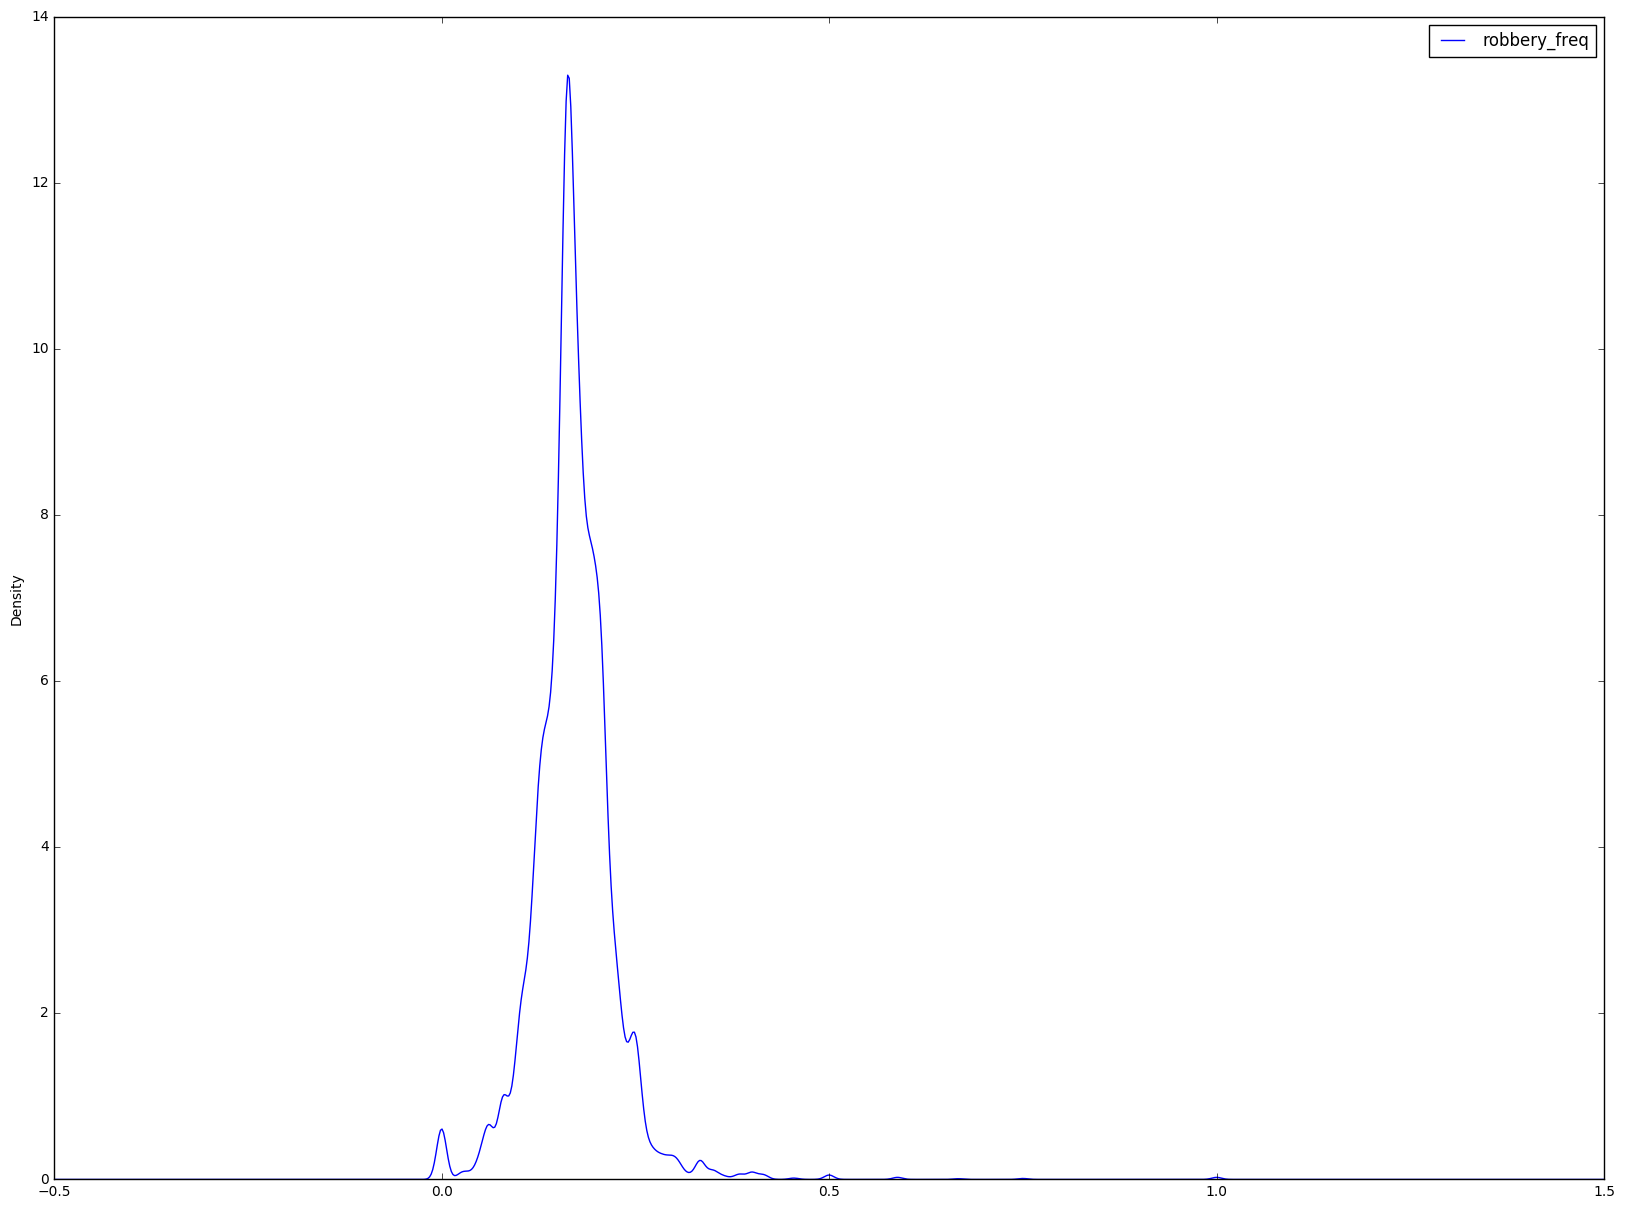

In [25]:
#Lets have a look at the robbery frequency distribution
final_stats.robbery_freq.plot(legend=True,kind='density')

In [26]:
#lets remove visitors who are clearly innocent
final_stats = final_stats[final_stats.robbery_freq!=0]

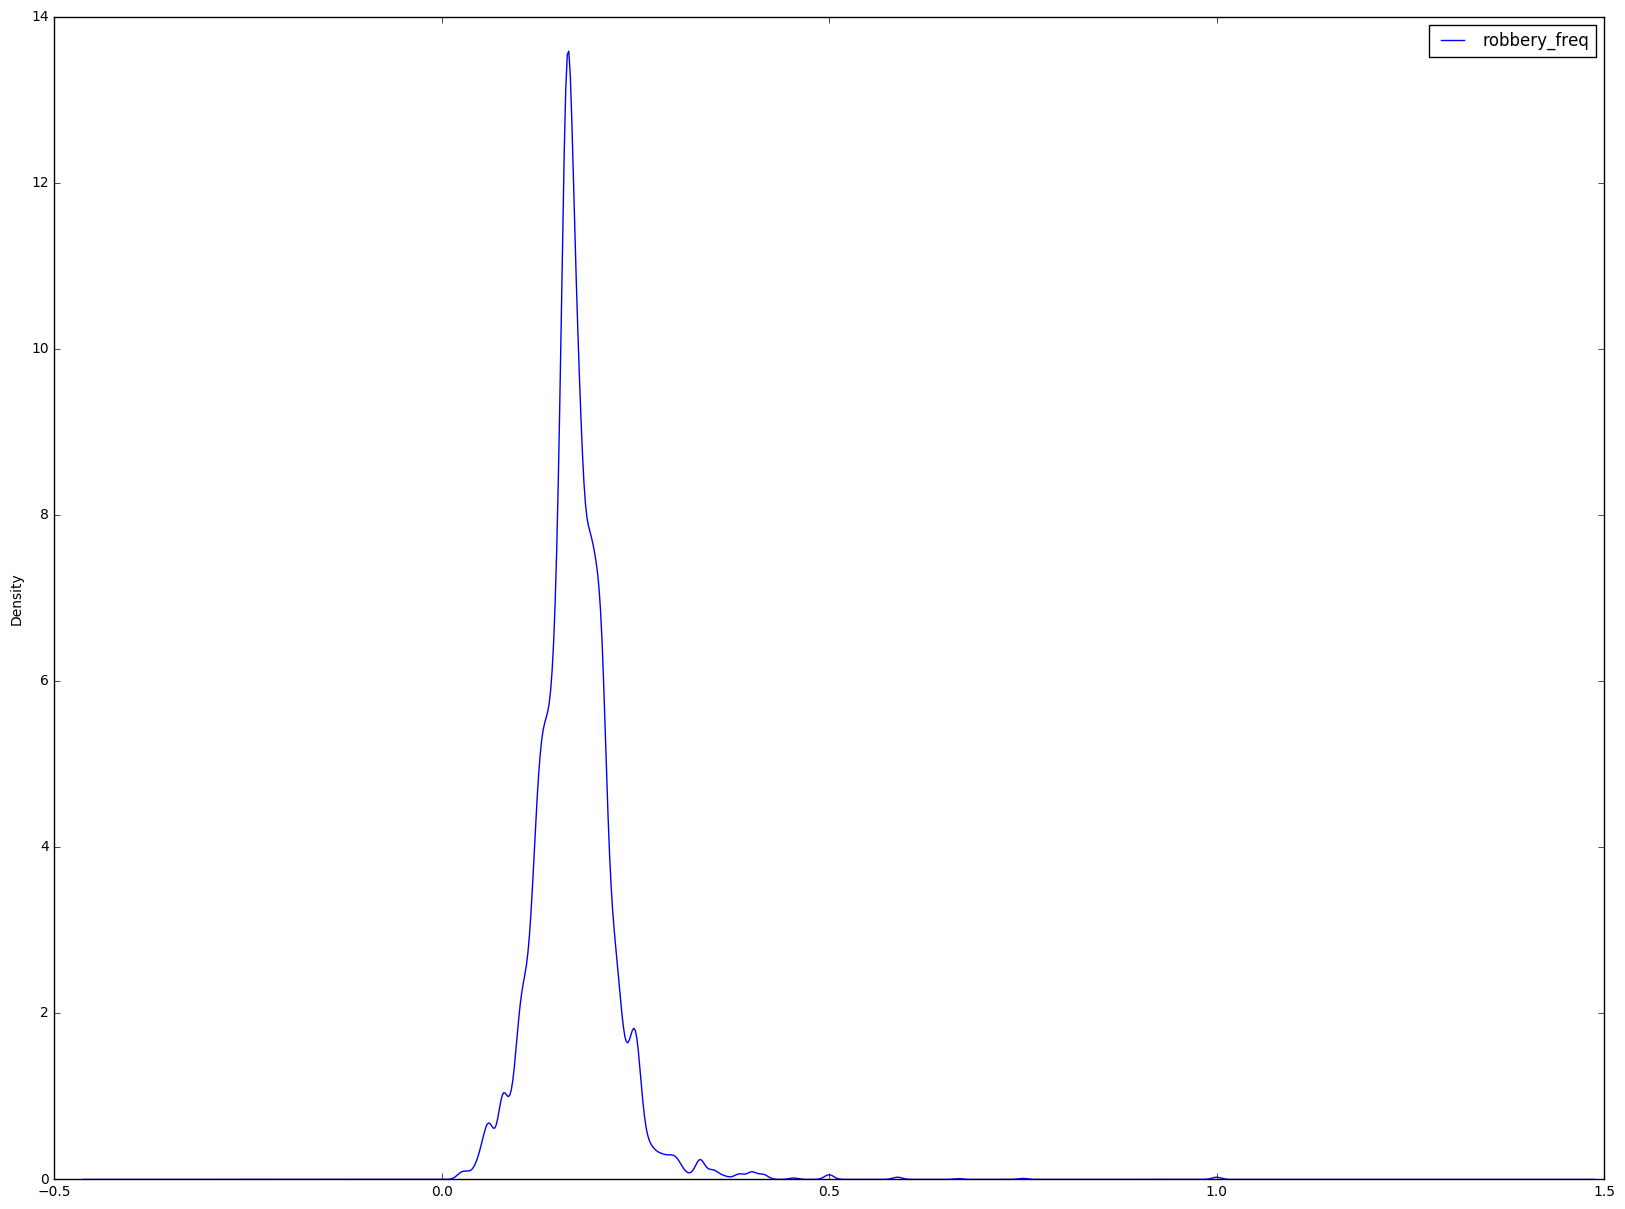

In [27]:
# Lets have another look at the distribution
final_stats.robbery_freq.plot(legend=True,kind='density')

In [50]:
final_stats.sort_values(['robbery_freq','robbery_count'],ascending=False).head()

,visit_date,name,dob,theft_date,theft_bool,not_robbery_count,robbery_count,total_visits,robbery_freq
1334,2016-06-22,Oneida Randall,1995-09-11,2016-06-22,1,0.0,11.0,11.0,1.0
7496,2016-07-21,Oneida Randall,1995-09-11,2016-07-21,1,0.0,11.0,11.0,1.0
7941,2016-07-23,Oneida Randall,1995-09-11,2016-07-23,1,0.0,11.0,11.0,1.0
8366,2016-07-25,Oneida Randall,1995-09-11,2016-07-25,1,0.0,11.0,11.0,1.0
9253,2016-07-29,Oneida Randall,1995-09-11,2016-07-29,1,0.0,11.0,11.0,1.0


In [29]:
final_stats.describe()

,theft_bool,not_robbery_count,robbery_count,total_visits,robbery_freq
count,42313.000000,42313.000000,42313.000000,42313.000000,42313.000000
mean,0.172240,59.889750,12.253350,72.143100,0.172240
std,0.377594,31.821258,6.716742,38.006944,0.051084
min,0.000000,0.000000,1.000000,2.000000,0.025000
25%,0.000000,34.000000,7.000000,41.000000,0.147059
50%,0.000000,58.000000,12.000000,70.000000,0.167785
75%,0.000000,80.000000,17.000000,95.000000,0.195652
max,1.000000,154.000000,30.000000,177.000000,1.000000


In [30]:
# Now we want to confirm in a statistical way which visitors could be a thief
# Lets select just the numerical columns and calculate the z-score
numeric_cols = final_stats.drop('theft_date',axis=1).select_dtypes(include=[np.number]).columns
zscore_vals = final_stats[numeric_cols].apply(zscore).sort_values(['robbery_count','robbery_freq'],ascending=False)
zscore_vals.head()

,theft_bool,not_robbery_count,robbery_count,total_visits,robbery_freq
243,2.192224,1.637612,2.642183,1.838025,0.764001
664,-0.456158,1.637612,2.642183,1.838025,0.764001
875,-0.456158,1.637612,2.642183,1.838025,0.764001
1292,2.192224,1.637612,2.642183,1.838025,0.764001
1489,-0.456158,1.637612,2.642183,1.838025,0.764001


In [49]:
#the results have the original index of the visitor in the dataframe, lets show the top 50 
idxs = zscore_vals.drop_duplicates().index.values
for i in idxs[:20]:
    print final_stats.ix[i]

visit_date           2016-06-17 00:00:00
name                        Karen Keeney
dob                  1993-12-25 00:00:00
theft_date           2016-06-17 00:00:00
theft_bool                             1
not_robbery_count                    112
robbery_count                         30
total_visits                         142
robbery_freq                    0.211268
Name: 243, dtype: object
visit_date           2016-06-19 00:00:00
name                        Karen Keeney
dob                  1993-12-25 00:00:00
theft_date           1970-01-01 00:00:00
theft_bool                             0
not_robbery_count                    112
robbery_count                         30
total_visits                         142
robbery_freq                    0.211268
Name: 664, dtype: object
visit_date           2016-06-16 00:00:00
name                      Judith Sanders
dob                  1993-08-26 00:00:00
theft_date           1970-01-01 00:00:00
theft_bool                             0
not_rob

In [32]:
results = final_stats.join(zscore_vals,rsuffix='_zscore').sort_values(['robbery_count','theft_bool'],ascending=False).drop_duplicates('name')

In [48]:
results.sort_values(['robbery_count','robbery_freq'],ascending=False).head()

,visit_date,name,dob,theft_date,theft_bool,not_robbery_count,robbery_count,total_visits,robbery_freq,theft_bool_zscore,not_robbery_count_zscore,robbery_count_zscore,total_visits_zscore,robbery_freq_zscore
243,2016-06-17,Karen Keeney,1993-12-25,2016-06-17,1,112.0,30.0,142.0,0.211268,2.192224,1.637612,2.642183,1.838025,0.764001
240,2016-06-17,Judith Sanders,1993-08-26,2016-06-17,1,112.0,27.0,139.0,0.194245,2.192224,1.637612,2.195532,1.759091,0.430758
296,2016-06-17,Lynn Bernhart,1995-11-13,2016-06-17,1,116.0,27.0,143.0,0.188811,2.192224,1.763315,2.195532,1.864337,0.324394
237,2016-06-17,Patricia Whitley,1993-06-08,2016-06-17,1,126.0,27.0,153.0,0.176471,2.192224,2.077574,2.195532,2.127450,0.082814
370,2016-06-17,Christine Victoria,1996-11-26,2016-06-17,1,139.0,27.0,166.0,0.162651,2.192224,2.486111,2.195532,2.469496,-0.187726


# Now that we have some more confirmation on which visitors could be a thief, lets find out who are the members of the gang

In [34]:
#First lets select just the data when there was a theft and lets do the crosstab
robbery_dates = final_stats[final_stats.theft_bool==1]
cross_tab = pd.crosstab(robbery_dates['name'],robbery_dates['visit_date'], margins=True)

In [47]:
#Basically here we see a matrix like dataset. Every cell tells us if a visitor was at the club at that date
cross_tab.head()

visit_date,2016-06-17 00:00:00,2016-06-22 00:00:00,2016-06-26 00:00:00,2016-06-29 00:00:00,2016-07-03 00:00:00,2016-07-07 00:00:00,2016-07-09 00:00:00,2016-07-21 00:00:00,2016-07-23 00:00:00,2016-07-25 00:00:00,...,2016-12-05 00:00:00,2016-12-12 00:00:00,2016-12-15 00:00:00,2016-12-18 00:00:00,2016-12-19 00:00:00,2016-12-22 00:00:00,2016-12-25 00:00:00,2016-12-30 00:00:00,2017-01-01 00:00:00,All
name,,,,,,,,,,,,,,,,,,,,,
Aaron Nelson,0,0,0,0,1,1,0,1,0,0,...,0,1,0,0,0,1,1,0,0,11
Ada Tejeda,1,0,1,1,1,0,1,1,1,0,...,1,1,0,1,0,0,0,1,0,22
Adam Berry,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,5
Adam Dorsette,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,4
Adam Johnson,0,0,1,1,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,1,13


In [36]:
# We do the crosstab because it is easier to find out the gang members with data in this format!
cross_tab_mat=cross_tab.reset_index().values

In [53]:
#With data in this format we can calculate the correlation between visitors
#We need to transpose the dataframe because the correlation is calculated between the columns
cross_tab.transpose().corr().head()

name,Aaron Nelson,Ada Tejeda,Adam Berry,Adam Dorsette,Adam Johnson,Adrian Whapham,Adrienne Raney,Adrienne Ruck,Alan Shoemake,Alfredo Vinci,...,Willie Gould,Willis Stewart,Woodrow Johnston,Yvette Vasquez,Yvonne Knowles,Yvonne Kouba,Zenobia Yahna,Zofia Treinen,Zoraida Hendrix,All
name,,,,,,,,,,,,,,,,,,,,,
Aaron Nelson,1.000000,0.959119,0.877803,0.840999,0.949540,0.930520,0.959812,0.962523,0.895460,0.877803,...,0.959341,0.909632,0.940764,0.652668,0.925802,0.860146,0.943522,0.955057,0.884159,0.968431
Ada Tejeda,0.959119,1.000000,0.917056,0.905482,0.965054,0.962449,0.987829,0.989812,0.908014,0.908014,...,0.980369,0.938204,0.954786,0.702710,0.948129,0.898973,0.972712,0.987829,0.883381,0.991164
Adam Berry,0.877803,0.917056,1.000000,0.842657,0.911518,0.875504,0.908512,0.899297,0.889474,0.852632,...,0.909088,0.865181,0.895460,0.619010,0.917112,0.852632,0.884137,0.908512,0.797630,0.918843
Adam Dorsette,0.840999,0.905482,0.842657,1.000000,0.865479,0.837112,0.907689,0.903638,0.797630,0.797630,...,0.876257,0.852530,0.840999,0.605231,0.855862,0.797630,0.867661,0.895563,0.779874,0.897319
Adam Johnson,0.949540,0.965054,0.911518,0.865479,1.000000,0.956638,0.965654,0.967948,0.911518,0.911518,...,0.964053,0.923244,0.949540,0.714485,0.907690,0.881421,0.951812,0.957549,0.847086,0.974999


# Unfortunatelly the data is too sparse and the correlation metric is not really helpfull to understand which visitors could be complices
That is why we need to calculate the correlation manually.
We calculate how many times two visitors were at the club when there was a theft, and we do this for every pair of visitors

In [37]:
#Lets count how many times two visitors were at the club on the same date, when a phone was stolen
from itertools import combinations
criminal_friends = []
for r1,r2 in combinations([x for x in cross_tab_mat],2):
    matches = [i for i,j in zip(r1,r2) if i==j and i!=0]
    criminal_friends.append((r1[0],r2[0], len(matches)))

In [38]:
#We clearly can see that Karen Keeney is the boss, and with her there are some other thiefs!
criminal_friends_ranking = sorted(criminal_friends, key=lambda x:x[2],reverse=True)
criminal_friends_ranking[:50]

[('Judith Sanders', 'Karen Keeney', 25),
 ('Dale Kirkwood', 'Karen Keeney', 24),
 ('Henry Brunson', 'Judith Sanders', 24),
 ('Judith Sanders', 'Lynn Bernhart', 24),
 ('Karen Keeney', 'Lynn Bernhart', 24),
 ('Arthur Freund', 'Karen Keeney', 23),
 ('Arthur Freund', 'Roger Ballance', 23),
 ('Christine Victoria', 'Karen Keeney', 23),
 ('Dale Kirkwood', 'Roger Ballance', 23),
 ('Daniel Laster', 'Lynn Bernhart', 23),
 ('Daniel Laster', 'Roger Ballance', 23),
 ('Henry Brunson', 'Karen Keeney', 23),
 ('Henry Brunson', 'Lynn Bernhart', 23),
 ('Henry Brunson', 'Patricia Whitley', 23),
 ('Judith Sanders', 'Patricia Whitley', 23),
 ('Karen Keeney', 'Patricia Whitley', 23),
 ('Karen Keeney', 'Roger Ballance', 23),
 ('Lynn Bernhart', 'Patricia Whitley', 23),
 ('Arthur Freund', 'Christine Victoria', 22),
 ('Arthur Freund', 'Daniel Laster', 22),
 ('Barbara Mchale', 'Karen Keeney', 22),
 ('Christine Victoria', 'Henry Brunson', 22),
 ('Christine Victoria', 'Patricia Whitley', 22),
 ('Dale Kirkwood', 'Da

In [39]:
# Lets select the top names as possible thiefs
# I use 21 as a threshold because the number of names retrieved is less than 20
criminal_names = set()
for t in criminal_friends_ranking:
    if t[2]>21:
        criminal_names.add(t[0])
        criminal_names.add(t[1])
print len(criminal_names)

15


In [40]:
#Finally here the list of possible thiefs of the nightclub!!
# If I have to choose, I would say that Karen Keeney is the boss! And the following names are most
# likely her accomplices
criminals = results[results.name.isin(criminal_names)].sort_values(['robbery_count','robbery_freq'],ascending=False)

In [43]:
criminals.head()

,visit_date,name,dob,theft_date,theft_bool,not_robbery_count,robbery_count,total_visits,robbery_freq,theft_bool_zscore,not_robbery_count_zscore,robbery_count_zscore,total_visits_zscore,robbery_freq_zscore
243,2016-06-17,Karen Keeney,1993-12-25,2016-06-17,1,112.0,30.0,142.0,0.211268,2.192224,1.637612,2.642183,1.838025,0.764001
240,2016-06-17,Judith Sanders,1993-08-26,2016-06-17,1,112.0,27.0,139.0,0.194245,2.192224,1.637612,2.195532,1.759091,0.430758
296,2016-06-17,Lynn Bernhart,1995-11-13,2016-06-17,1,116.0,27.0,143.0,0.188811,2.192224,1.763315,2.195532,1.864337,0.324394
237,2016-06-17,Patricia Whitley,1993-06-08,2016-06-17,1,126.0,27.0,153.0,0.176471,2.192224,2.077574,2.195532,2.127450,0.082814
370,2016-06-17,Christine Victoria,1996-11-26,2016-06-17,1,139.0,27.0,166.0,0.162651,2.192224,2.486111,2.195532,2.469496,-0.187726


In [46]:
criminals[['name','dob']]

,name,dob
243,Karen Keeney,1993-12-25
240,Judith Sanders,1993-08-26
296,Lynn Bernhart,1995-11-13
237,Patricia Whitley,1993-06-08
370,Christine Victoria,1996-11-26
340,Henry Brunson,1996-06-21
2211,Daniel Laster,1995-12-31
333,Roger Ballance,1996-05-16
356,Arthur Freund,1996-09-07
235,Dale Kirkwood,1993-05-22


# Conclusion

The proposed list shows the possible thieves, but there is another road that could be explored.

It is possible that the thieves went to the club just once and stole the phones.

As a future exercise it would be interesting to cover this other scenario as well.